# Semantic Segmentation

No Ng lecture, but Stanford's deep learning course has an [excellent video lecture on this topic](https://www.youtube.com/watch?v=nDPWywWRIRo).  Please watch 00:08:00 - 00:33:00 or so (or keep watching to the end: it's pretty interesting stuff).  

So far, we've been concerned with the problem of object recognition: a mapping from an image to a class (or a probability of membership in each of N disjoint classes).  This is a useful thing as it allows us to determine the subject in an image.  It's also highly reductive, in the sense that we throw away all of the information about where in the image the object in question was located.  We were able to recover this information in some sense through class activation mapping (CAM).  However, it's important to think about the question that class activation mapping is answering: *What was the neural network looking at when it made its decision?*.  Thus, if one was looking at a picture of a ship, the network may have been looking at a flat horizon, or the ocean surface and saying *the only class that shows up on the ocean is a ship, so I'm going to classify this image as a ship.* Another case that I noticed was when classifying deer, the class activation map often indicated that the void space between the deer's legs was a focus of attention.  Or take the following example, in which CAM hones in on a blurry representation of the face of both the horse and the dog: clearly, the other pixels composing the creature were not used as evidence.

<img src=cam.png/>

An alternative and more explicit question that we can ask is: *what pixels in this image belong to class k?* As it turns out, we can code that question with a neural network.  

What should be the inputs and outputs of this neural network?  Of course, the input is the same as for object recognition: usually a 3-band color image.  However, now instead of an array of probabilities for the entire image, we will have *an array of probabilities for each pixel*, thus our output image should be an image with the same width and height as the input, with N bands, where each band contains the probability of class membership.  Note that for the problem that we will address in this section, we will only use two classes (member of target class versus not member).  When this is the case, the output needs to only be one band: probability of membership.  Since these classes are disjoint, we can subtract the probability of membership from one to get the probability of not-membership.  Thus, we will be taking a color image, and outputting for each pixel the probability that it is a member of our target class.  

This also defines our needs in terms of training data, and they are somewhat more onerous.  Rather than having pictures and their associated labels, we need pictures and an associated mask, in which each pixel in the member class has been labeled.  Usually this means that someone has gone and drawn a polygon around the interest object in each image.  That's alot of work!  Fortunately, this has mostly been done for us already.  An excellent and freely available data source that contains exactly this kind of labeled data is called the [COCO dataset](http://cocodataset.org/#home).  There is a bit of overhead associated with getting the annotations in a format that we can easily use and extracting the class of interest.  I have done this preprocessing step for you for a very specific subset of images: those containing dogs.  Let's have a look at some of these images and their associated masks.  The data can be found [here](https://drive.google.com/open?id=1Bn17ETcn5JAILXSy1mdRmO61ziP69ctG).

In [1]:
import keras.preprocessing as kp

data_gen_args = dict(
rotation_range=30,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.3,horizontal_flip=True)
image_datagen = kp.image.ImageDataGenerator(preprocessing_function=lambda x: x/255.,**data_gen_args)
mask_datagen = kp.image.ImageDataGenerator(**data_gen_args)

target_size = (240,320)
batch_size = 8

image_generator = image_datagen.flow_from_directory(
    './imgs_train',
    class_mode=None,
    seed=0,target_size=target_size,batch_size=batch_size)

mask_generator = mask_datagen.flow_from_directory(
    './masks_train',
    class_mode=None,
    seed=0,target_size=target_size,color_mode='grayscale',batch_size=batch_size)

image_generator_test = image_datagen.flow_from_directory(
    './imgs_test',
    class_mode=None,
    seed=0,target_size=target_size,batch_size=batch_size)

mask_generator_test = mask_datagen.flow_from_directory(
    './masks_test',
    class_mode=None,
    seed=0,target_size=target_size,color_mode='grayscale',batch_size=batch_size)

train_generator = zip(image_generator, mask_generator)
test_generator = zip(image_generator_test,mask_generator_test)

Using TensorFlow backend.


Found 2736 images belonging to 1 classes.
Found 2736 images belonging to 1 classes.
Found 305 images belonging to 1 classes.
Found 305 images belonging to 1 classes.


Let's have a look at the above code, because it's doing something slightly different from what we've seen before.  Specifically, we're doing two new things.  First, we're storing our training and test data out of core: this dataset is very large, and we don't want to put it all in memory, thus we use the ImageDataGenerator class, which will read images from a directory during runtime, normalize them according to a preprocessing function (dividing the input by 255 for example), and perform our second new thing: *data augmentation*.  Data augmentation relies on the idea that the semantic content of an image remains the same regardless of small variations.  For example, a dog is still a dog even after rotating an image by 20 degrees, or flipping across its axis, or zooming in or out a little bit.  By applying these operations to our training examples, the network can never rely on a single pixel's value, thus reducing the possibility of [overfitting](https://en.wikipedia.org/wiki/Overfitting), and also enhances the generalizability of the network.   

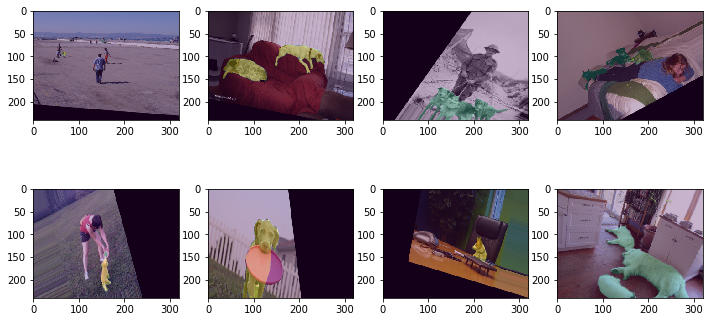

In [3]:
import matplotlib.pyplot as plt

img_batch,mask_batch = next(train_generator)
fig,axs = plt.subplots(nrows=2,ncols=4,figsize=(12,6))
counter = 0
for r in axs:
    for ax in r:
        ax.imshow(img_batch[counter])
        ax.imshow(mask_batch[counter,:,:,0],alpha=0.3)
        counter += 1
plt.show()

Look all the adorable doggos!  Let's see if we can train a network that can reproduce these masks.  

Obviously, we're going to need to come up with some different ideas than what we've seen so far, because continously downscaling the image isn't going to work: the output needs to be the same size as the input.  However, we'll need to do some downscaling, both for the sake of computational efficiency and to increase the size of our network's perceptive field (the parts of the image that go into classifying a particular pixel).  A network architecture that has proven extremely useful for this task is called [U-net](https://arxiv.org/pdf/1505.04597.pdf), so called because it resembles a U.  It borrows some ideas from ResNet as well in that there are skip connections, although these are a bit different than the ResNet ones.  U-net looks like this:
<img src=unet.svg width=800/>
Note that to save space, when the convolution kernel size is not specified, it's 3x3.  

What does this network do?  Essentially, what we have is a sequence of image downscalings, followed by a sequence of upscalings to get us back to the original image size.  Note that at no point do we have a fully-connected layer or global average pool or flatten or anything else that would make the feature maps not images.  Such an architecture is referred to as a *fully convolutional network* or a FCN.   

Without the skip connections, using this architecture for the problem we're considering does work, however the resulting segmentation tends to be very "low-res" for lack of a better word: edges aren't captured well and spatial localization is poor.  Why is this?  During the downsampling step, we're throwing away information by distilling the contents of a neighborhood of four pixels into a single value.  As we are well aware, it isn't possible to recover the original image from this reduced representation.  U-net solves this problem by concatenating every upsampled layer to the previously computed and commensurately sized downsampling layer.  Thus, each layer gets access to the features that were generated during downsampling at its own scale *along with the larger scale information produced by further downsampling*.

Note that the figure above shows a U-net that downsamples twice (and upsamples twice).  However, in practice deeper networks are often used.  The following code gives a U-net that downsamples and upsamples only once.  **Extend the network below such that it has a total of five downsampling steps and four upsampling steps.**  This will yield a network with a maximum number of feature maps of 1024!  This is alot: the model is very large and we will definitely need to run it on a GPU.  You also may have to adjust your batch size so that everything fits in GPU memory.   






In [4]:
import keras.layers as kl
import keras.models as km

def unet(input_size):
    inputs = kl.Input(input_size)
    # Level 1
    conv1 = kl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = kl.BatchNormalization()(conv1)
    conv1 = kl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = kl.BatchNormalization()(conv1)
    pool1 = kl.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Level 2
    conv2 = kl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = kl.BatchNormalization()(conv2)
    conv2 = kl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = kl.BatchNormalization()(conv2)
    pool2 = kl.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Level 3
    conv3 = kl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = kl.BatchNormalization()(conv3)
    conv3 = kl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = kl.BatchNormalization()(conv3)
    pool3 = kl.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Level 4
    conv4 = kl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = kl.BatchNormalization()(conv4)
    conv4 = kl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = kl.BatchNormalization()(conv4)
    pool4 = kl.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Level 5
    conv5 = kl.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = kl.BatchNormalization()(conv5)
    conv5 = kl.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = kl.BatchNormalization()(conv5)
    
    # Back to Level 4
    depool6 = kl.UpSampling2D(size=(2, 2))(conv5)
    upconv6 = kl.Conv2D(512, 2, activation='linear', padding='same', kernel_initializer='he_normal')(depool6)
    merge6 = kl.concatenate([conv4, upconv6], axis=3)
    conv6 = kl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = kl.BatchNormalization()(conv6)
    conv6 = kl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = kl.BatchNormalization()(conv6)
    
    # Back to Level 3
    depool7 = kl.UpSampling2D(size=(2, 2))(conv6)
    upconv7 = kl.Conv2D(256, 2, activation='linear', padding='same', kernel_initializer='he_normal')(depool7)
    merge7 = kl.concatenate([conv3, upconv7], axis=3)
    conv7 = kl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = kl.BatchNormalization()(conv7)
    conv7 = kl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = kl.BatchNormalization()(conv7)
    
    # Back to Level 2
    depool8 = kl.UpSampling2D(size=(2, 2))(conv7)
    upconv8 = kl.Conv2D(128, 2, activation='linear', padding='same', kernel_initializer='he_normal')(depool8)
    merge8 = kl.concatenate([conv2, upconv8], axis=3)
    conv8 = kl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = kl.BatchNormalization()(conv8)
    conv8 = kl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = kl.BatchNormalization()(conv8)

    # Back to level 1
    depool9 = kl.UpSampling2D(size=(2,2))(conv8)
    upconv9 = kl.Conv2D(64, 2, activation='linear', padding='same', kernel_initializer='he_normal')(depool9)
    merge9 = kl.concatenate([conv1,upconv9], axis = 3)
    conv9 = kl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = kl.BatchNormalization()(conv9)
    conv9 = kl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = kl.BatchNormalization()(conv9)
    conv10 = kl.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = km.Model(input=inputs, output=conv10)

    return model

model = unet((240,320,3))

/Users/Fred/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Once we have coded U-net, we can train it just like any other model.  Our loss function for this model is going to be binary crossentropy: this is the appropriate loss for the case in which we only have two classes.

Also, note that this problem requires a somewhat reduced learning rate compared to previous examples.  A good starting value is $10^{-4}$.

In [5]:
import keras.optimizers as ko
model.compile(
    optimizer=ko.Adam(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 320, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 320, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

As in other CNNs, we'll want to checkpoint our model weights and we'll want to specify a learning rate schedule.  I make no claim that this learning rate schedule is the best.  For a correctly implemented U-net, it seems to work okay for me.  

In [6]:
import keras.callbacks as kc
filepath = './checkpoints_2.h5'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = kc.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 80:
        lr /=16.
    elif epoch > 40:
        lr /= 8.
    elif epoch > 25:
        lr /= 4.
    elif epoch > 10:
        lr /= 2.
    print('Learning rate: ', lr)
    return lr

lr_scheduler = kc.LearningRateScheduler(lr_schedule)

Finally, we can fit the model as before.  However, we'll use the fit_generator command as we want to fit the data from a generator rather than from a numpy array.  *When you call this command, it's going to take a very long time to run, up to 8 hours on a GPU.*  

In [7]:
model.load_weights('checkpoints_2.h5')
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=(3041-305)//batch_size,
#     epochs=200,
#     validation_data=test_generator,
#     validation_steps=301//8,
#     callbacks=[checkpoint,lr_scheduler]
# )

Once the model is done training, we can make predictions on the test data:

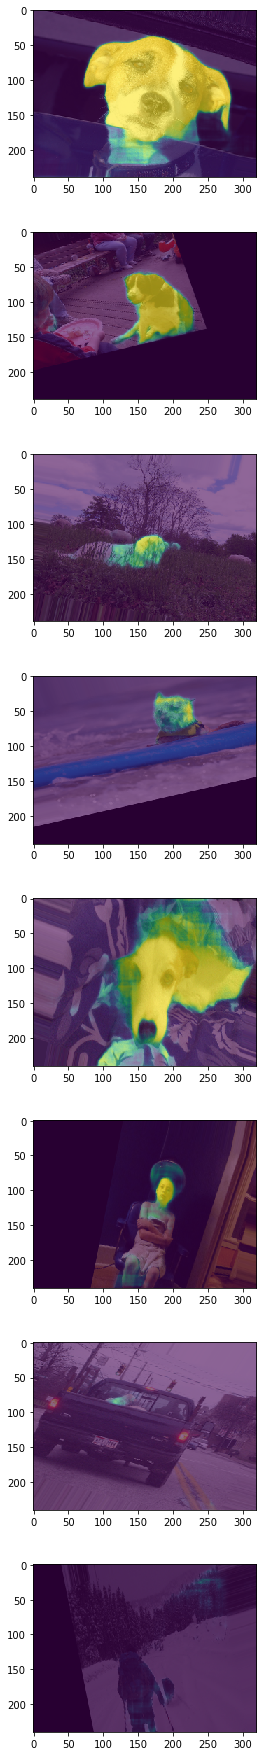

In [8]:
# Make a prediction on the test set

imgs = image_generator_test.next()
masks_true = mask_generator_test.next()
masks = model.predict(imgs)
fig,axs = plt.subplots(nrows=batch_size,figsize=(4,4*batch_size))
for img,mask,ax in zip(imgs,masks,axs):
    ax.imshow(img.squeeze())
    ax.imshow(mask.squeeze(),alpha=0.6,vmin=0,vmax=1)